## Binary Image Classification: Pizza vs. Ice Cream
Our goal is to build a binary image classifier. Through applying different machine learning classification techniques, we are hoping to differentiate between images of pizza and ice cream.

#### Our dataset
https://www.kaggle.com/datasets/hemendrasr/pizza-vs-ice-cream 

#### Libraries that we are using

In [2]:
# for image manipulation
import cv2
from scipy import ndimage

# for displaying graphs and image
import matplotlib.pyplot as plt

# for machine learning
import sklearn

# general purpose 
import os
import numpy as np

#### Idea of Roadmap:
+ bring dataset into notebook 
+ modify images as necessary
+ do pca?
+ try running knn
+ try running through an svm, try a color histogram, etc

(512, 512, 3)


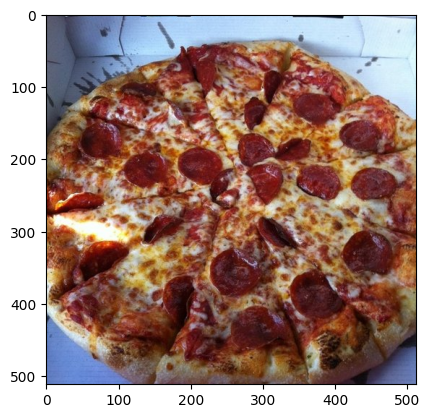

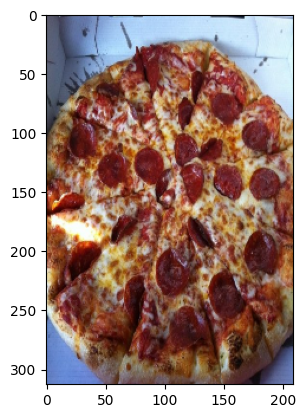

In [4]:
filename = "1001116.jpg"
test = cv2.imread("pizza_not_pizza/pizza/" + filename)
print(test.shape)

# show image in matplotlib plot
plt.imshow(cv2.cvtColor(test, cv2.COLOR_RGBA2BGR)) # channels in cv2 are reversed so has to be swapped
plt.show()

res_img = cv2.resize(test,(209, 313))
plt.imshow(cv2.cvtColor(res_img, cv2.COLOR_RGBA2BGR)) # channels in cv2 are reversed so has to be swapped
plt.show()

#### Transforming data
These steps will take the training data, transform it, and output the cleaned, ready to use data into a new dataset folder. The transformation steps include rotating all images to be landscape, changing the aspect ratio of all images to 2:3, and decreasing resolution by half.

In [7]:
paths = ['/not_pizza/', '/pizza/']

for path in paths:
    os.makedirs('clean_data' + path, exist_ok=True)
    
    for filename in os.listdir("pizza_not_pizza" + path):
        # load image
        img = cv2.imread("pizza_not_pizza" + path + filename)
    
        # if the image is horizontal, rotate so it's vertical
        if img.shape[0] > img.shape[1]:
            rot_img = np.transpose(img, (1, 0, 2))  
        else:
            rot_img = img
        
        # Semi random decision, change if necessary
        # reshape all images to be 2:3 and about half of original dimensions, that is 209 by 313 
        # (since all original images have one dim that is 626)
        new_img = cv2.resize(rot_img,(313, 209)) # width by height so axes are swapped when passed in

        # write image to new directory, preserving dir structure & filenames
        new_path = 'clean_data' + path + filename
        cv2.imwrite(new_path, new_img)
    

In [9]:
# create array of labels, with pizza as class 0 and ice cream as class 1
num_pizza = len([f for f in os.listdir("clean_data/pizza")])
num_icecream = len([f for f in os.listdir("clean_data/icecream")])

y_a = np.zeros(num_pizza)
y_b = np.ones(num_icecream)
y = np.concatenate((y_a, y_b))

# make sure all data is loaded
assert len(y) == len(X)
assert len(X) == 1032

AssertionError: 

In [8]:
# load in data
X = []
paths = ['/not_pizza/', '/pizza/']
for path in paths:
    for filename in os.listdir("clean_data" + path):
        # load image
        img_array = cv2.imread("clean_data" + path + filename)
        X.append(img_array.flatten()) # flatten to 1D array
    print(f"files from {path} loaded")
    
X = np.array(X)
print(X.shape)

files from /not_pizza/ loaded
files from /pizza/ loaded
(1966, 196251)


In [ ]:
len(os.listdir("clean_data" + path))

#### Implementing K Nearest Neighbors
For starters, we tried the K Nearest Neighbors approach because it was one of the simplest and allowed us to make sure we had loaded the dataset correctly

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)
knn_model.score(X_test, y_test)


0.7439613526570048

The score is ok (ranging from about .67 to .74). There's probably a way we can do this better.

#### Trying Principal Component Analysis
Hopefully using PCA we can find the most informative components and reduce the dimensionality of the data.

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=200).fit(X_train) # keeps 200 most informative components

# data mapped onto pca space
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
# What can this tell us about our data?


In [21]:
# Trying KNN on this transformed data
knn_model_pca = KNeighborsClassifier(n_neighbors=3)
knn_model_pca.fit(X_train_pca, y_train)
knn_model_pca.score(X_test_pca, y_test)

0.7681159420289855

#### Helpful Links to resources so far:
Generally:
+ https://scipy-lectures.org/advanced/image_processing/

For Principal Component Analysis:
+ https://towardsdatascience.com/principal-component-analysis-pca-explained-visually-with-zero-math-1cbf392b9e7d
+ https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html#sphx-glr-auto-examples-applications-plot-face-recognition-py
+ https://scikit-learn.org/stable/modules/decomposition.html#pca